# Final: Logistic Regression

# Libraries

In [1]:
# Libraries

# Standard
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)


# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE
from sklearn.utils import shuffle

# Modeling

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve
from sklearn.metrics import precision_score, recall_score, f1_score

# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV

# Cross validation

from sklearn.model_selection import cross_val_score

# Feature importance
import shap 

# Saving models

import joblib
import os

c:\Users\alexa\anaconda3\envs\employee_attrition_dec24\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Dataset

In [2]:
output_path = r"C:\Users\alexa\OneDrive\AlexPerez\Dokumente\2 Soros\Data Science\Projects\employee_attrition_Dec24\data\raw\employee_attrition_synthetic_IT.csv"
df= pd.read_csv(output_path)

# Remove Employee_ID column
if 'Employee_ID' in df.columns:
    df = df.drop(columns=['Employee_ID'])
    print("'Employee_ID' column removed.")
else:
    print("'Employee_ID' column not found.")

display(df.head())
display(df.info())

'Employee_ID' column removed.


,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12,Q13,Q14,Q15,Q16,Age,Tenure,Gender,Department,Salary,Overtime,Distance_to_Work,Attrition
0,4,4,5,5,5,4,5,5,4,4,4,4,5,5,4,5,43,2,Male,Development,104715,Yes,0.00,No
1,5,5,4,5,4,4,5,5,5,4,4,5,5,4,5,4,50,1,Female,QA,73815,No,8.71,No
2,1,1,1,2,2,2,2,1,2,1,1,1,1,1,1,2,44,4,Male,Development,76687,Yes,0.00,Yes
3,2,2,1,1,2,2,2,2,1,1,1,2,2,1,1,1,42,0,Male,Development,99861,No,0.00,Yes
4,5,5,5,5,5,5,5,4,4,4,5,4,5,5,4,5,37,4,Male,Support,115343,No,4.62,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Q1                5000 non-null   int64  
 1   Q2                5000 non-null   int64  
 2   Q3                5000 non-null   int64  
 3   Q4                5000 non-null   int64  
 4   Q5                5000 non-null   int64  
 5   Q6                5000 non-null   int64  
 6   Q7                5000 non-null   int64  
 7   Q8                5000 non-null   int64  
 8   Q9                5000 non-null   int64  
 9   Q10               5000 non-null   int64  
 10  Q11               5000 non-null   int64  
 11  Q12               5000 non-null   int64  
 12  Q13               5000 non-null   int64  
 13  Q14               5000 non-null   int64  
 14  Q15               5000 non-null   int64  
 15  Q16               5000 non-null   int64  
 16  Age               5000 non-null   int64  


None

In [3]:
# Separate features and target
X = df.drop(columns=['Attrition']) 
y = df['Attrition']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("Train-test split completed.")

Train-test split completed.


In [4]:
# Encoding categorical variables

# Define categorical and numerical features
categorical_features = ['Gender', 'Department', 'Overtime']
numerical_features = ['Age', 'Tenure', 'Salary', 'Distance_to_Work']

# One-Hot Encoding for categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ],
    remainder='passthrough'  # Keep numerical features as they are for now
)

# Apply One-Hot Encoding on training and test sets
X_train_encoded = preprocessor.fit_transform(X_train)
X_test_encoded = preprocessor.transform(X_test)

print("Categorical variables encoded.")

Categorical variables encoded.


In [5]:
# Trying to check where DevOps is dropped
# Inspect categories learned by the OneHotEncoder
categories = preprocessor.named_transformers_['cat'].categories_

# Print the categories for the 'Department' feature
print("Categories for 'Department':", categories[categorical_features.index('Department')])

Categories for 'Department': ['DevOps' 'Development' 'Management' 'QA' 'Support']


In [6]:
# Scaling numerical features

# Initialize RobustScaler
scaler = RobustScaler()

# Apply RobustScaler to numerical features only
X_train_encoded[:, -len(numerical_features):] = scaler.fit_transform(
    X_train_encoded[:, -len(numerical_features):]
)
X_test_encoded[:, -len(numerical_features):] = scaler.transform(
    X_test_encoded[:, -len(numerical_features):]
)

print("Numerical features scaled using RobustScaler.")

Numerical features scaled using RobustScaler.


In [7]:
# Trying to check where DevOps was dropped

# Get feature names for one-hot-encoded columns
one_hot_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)

# Identify the Q12+ feature names (if applicable)
q12_features = [col for col in X.columns if col.startswith('Q')]

# Combine all feature names
all_feature_names = list(one_hot_feature_names) + numerical_features + q12_features

# Verify feature names
print("All Feature Names:", all_feature_names)
print("Number of Features:", len(all_feature_names))

print("One-Hot Encoded Feature Names:", one_hot_feature_names)

All Feature Names: ['Gender_Male', 'Department_Development', 'Department_Management', 'Department_QA', 'Department_Support', 'Overtime_Yes', 'Age', 'Tenure', 'Salary', 'Distance_to_Work', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11', 'Q12', 'Q13', 'Q14', 'Q15', 'Q16']
Number of Features: 26
One-Hot Encoded Feature Names: ['Gender_Male' 'Department_Development' 'Department_Management'
 'Department_QA' 'Department_Support' 'Overtime_Yes']


In [8]:
# Trying to check where DevOps was dropped

# Check DevOps presence in one-hot encoded columns
print("Is 'Department_DevOps' present in one-hot encoded features?:",
      'Department_DevOps' in one_hot_feature_names)

# Check the corresponding index
if 'Department_DevOps' in one_hot_feature_names:
    devops_index = list(one_hot_feature_names).index('Department_DevOps')
    print("Index of 'Department_DevOps':", devops_index)

    # Check values in X_train_encoded
    print("Values for 'Department_DevOps':", X_train_encoded[:, devops_index])

Is 'Department_DevOps' present in one-hot encoded features?: False


In [9]:
# Addressing class imbalances

# Apply SMOTE to training data only
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_encoded, y_train)

# Shuffle the balanced data
X_train_balanced, y_train_balanced = shuffle(X_train_balanced, y_train_balanced, random_state=42)

print("SMOTE applied to training data. Classes balanced.")

# Visualizing new shape after SMOTE
print("Shape of X_train before SMOTE:", X_train_encoded.shape)
print("Shape of X_train after SMOTE:", X_train_balanced.shape)
print("Shape of y_train before SMOTE:", y_train.shape)
print("Shape of y_train after SMOTE:", y_train_balanced.shape)

SMOTE applied to training data. Classes balanced.
Shape of X_train before SMOTE: (4000, 26)
Shape of X_train after SMOTE: (5068, 26)
Shape of y_train before SMOTE: (4000,)
Shape of y_train after SMOTE: (5068,)


In [10]:
# Trying to check where DevOps was dropped
# Save feature names before SMOTE
feature_names_before_smote = all_feature_names
print("Features before SMOTE:", feature_names_before_smote)
print("Shape after SMOTE:", X_train_balanced.shape)

Features before SMOTE: ['Gender_Male', 'Department_Development', 'Department_Management', 'Department_QA', 'Department_Support', 'Overtime_Yes', 'Age', 'Tenure', 'Salary', 'Distance_to_Work', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11', 'Q12', 'Q13', 'Q14', 'Q15', 'Q16']
Shape after SMOTE: (5068, 26)


# Modeling : Logistic Regression

In [11]:
# Train Logistic Regression
lr_model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
lr_model.fit(X_train_balanced, y_train_balanced)

# Evaluate Logistic Regression
y_pred_lr = lr_model.predict(X_test_encoded)
y_pred_prob_lr = lr_model.predict_proba(X_test_encoded)[:, 1]

# Print Evaluation Metrics
print("Logistic Regression Results:")
print(classification_report(y_test, y_pred_lr))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lr))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_prob_lr))

Logistic Regression Results:
              precision    recall  f1-score   support

          No       0.79      0.70      0.74       633
         Yes       0.57      0.69      0.62       367

    accuracy                           0.69      1000
   macro avg       0.68      0.69      0.68      1000
weighted avg       0.71      0.69      0.70      1000

Confusion Matrix:
[[442 191]
 [114 253]]
ROC-AUC Score: 0.7425520100210492


Precision (No: 0.79, Yes: 0.57):
The model performs well in identifying the majority class (No), but struggles to correctly identify the minority class (Yes), as indicated by lower precision for the "Yes" class.

Recall (No: 0.70, Yes: 0.69):
The recall for "Yes" is reasonable (0.69), meaning the model captures a significant portion of employees who left the company.
F1-Score:

The F1-score for "Yes" (0.62) indicates a balance between precision and recall, but it's lower than for "No".
ROC-AUC: 0.74:

Indicates a moderately good ability to distinguish between the two classes.

# Modeling Optimization

In [12]:
# Logistic Regression Hyperparameter Grid
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'saga']
}

grid_lr = GridSearchCV(LogisticRegression(class_weight='balanced', max_iter=1000), param_grid, cv=5, scoring='roc_auc')
grid_lr.fit(X_train_balanced, y_train_balanced)

# Best Parameters and Score
print("Best Parameters:", grid_lr.best_params_)
print("Best ROC-AUC Score:", grid_lr.best_score_)

# Evaluate on Test Set
best_lr = grid_lr.best_estimator_
y_pred_lr = best_lr.predict(X_test_encoded)
y_pred_prob_lr = best_lr.predict_proba(X_test_encoded)[:, 1]

print("ROC-AUC on Test Set:", roc_auc_score(y_test, y_pred_prob_lr))

Best Parameters: {'C': 0.01, 'solver': 'saga'}
Best ROC-AUC Score: 0.7561981207901532
ROC-AUC on Test Set: 0.7421043342760352


In [13]:
# Model re-run with best parameters

# Re-train the Logistic Regression model with best parameters
best_lr = LogisticRegression(C=0.01, solver='saga', class_weight='balanced', max_iter=1000)
best_lr.fit(X_train_balanced, y_train_balanced)

# Make predictions
y_pred_best_lr = best_lr.predict(X_test_encoded)
y_pred_prob_best_lr = best_lr.predict_proba(X_test_encoded)[:, 1]

# Evaluate the model
print("Classification Report for Tuned Logistic Regression:")
print(classification_report(y_test, y_pred_best_lr))

print("Confusion Matrix for Tuned Logistic Regression:")
print(confusion_matrix(y_test, y_pred_best_lr))

# Compute ROC-AUC
roc_auc_best_lr = roc_auc_score(y_test, y_pred_prob_best_lr)
print("ROC-AUC Score for Tuned Logistic Regression:", roc_auc_best_lr)

Classification Report for Tuned Logistic Regression:
              precision    recall  f1-score   support

          No       0.79      0.70      0.74       633
         Yes       0.57      0.68      0.62       367

    accuracy                           0.69      1000
   macro avg       0.68      0.69      0.68      1000
weighted avg       0.71      0.69      0.70      1000

Confusion Matrix for Tuned Logistic Regression:
[[444 189]
 [116 251]]
ROC-AUC Score for Tuned Logistic Regression: 0.7421043342760352


In [14]:
# Saving the model and the threshold indentified later as the best one (0.3)

# Paths to save the model and threshold
model_path = r"C:\Users\alexa\OneDrive\AlexPerez\Dokumente\2 Soros\Data Science\Projects\employee_attrition_Dec24\models\logistic_regression_model.pkl"
threshold_path = r"C:\Users\alexa\OneDrive\AlexPerez\Dokumente\2 Soros\Data Science\Projects\employee_attrition_Dec24\models\logistic_regression_threshold.pkl"

# Save the model
joblib.dump(best_lr, model_path)
print(f"Model saved at: {model_path}")

# Save the threshold (adjusted at 0.3)
final_threshold = 0.3
joblib.dump(final_threshold, threshold_path)
print(f"Threshold saved at: {threshold_path}")

Model saved at: C:\Users\alexa\OneDrive\AlexPerez\Dokumente\2 Soros\Data Science\Projects\employee_attrition_Dec24\models\logistic_regression_model.pkl
Threshold saved at: C:\Users\alexa\OneDrive\AlexPerez\Dokumente\2 Soros\Data Science\Projects\employee_attrition_Dec24\models\logistic_regression_threshold.pkl


In [15]:
print("All Feature Names:", all_feature_names)
print("Number of Features:", len(all_feature_names))

All Feature Names: ['Gender_Male', 'Department_Development', 'Department_Management', 'Department_QA', 'Department_Support', 'Overtime_Yes', 'Age', 'Tenure', 'Salary', 'Distance_to_Work', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11', 'Q12', 'Q13', 'Q14', 'Q15', 'Q16']
Number of Features: 26


# Logistic Regression Threshold Adjustment

   Threshold  Precision    Recall  F1-Score
0        0.1   0.367000  1.000000  0.536942
1        0.2   0.449409  0.931880  0.606383
2        0.3   0.484581  0.899183  0.629771
3        0.4   0.520572  0.792916  0.628510
4        0.5   0.570455  0.683924  0.622057
5        0.6   0.591584  0.651226  0.619974
6        0.7   0.604027  0.490463  0.541353
7        0.8   1.000000  0.002725  0.005435


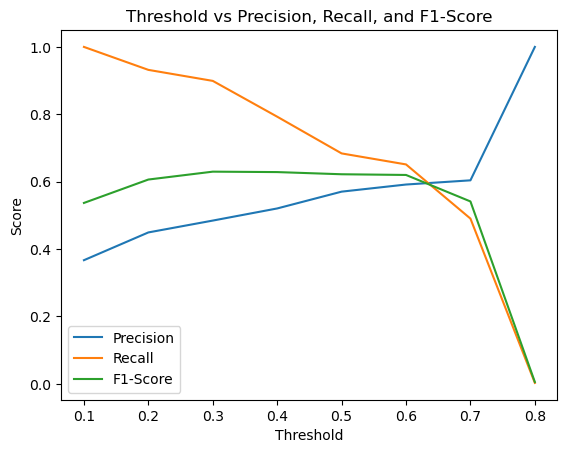

In [16]:
le = LabelEncoder()
y_test_encoded = le.fit_transform(y_test)  # 'No' -> 0, 'Yes' -> 1

# Get predicted probabilities from the best Logistic Regression model
y_pred_prob_lr = best_lr.predict_proba(X_test_encoded)[:, 1]

# Define thresholds to evaluate
thresholds = np.arange(0.1, 0.9, 0.1)
results = []

for threshold in thresholds:
    # Adjust predictions based on the threshold
    y_pred_adjusted = (y_pred_prob_lr >= threshold).astype(int)
    
    # Compute metrics
    precision = precision_score(y_test_encoded, y_pred_adjusted)
    recall = recall_score(y_test_encoded, y_pred_adjusted)
    f1 = f1_score(y_test_encoded, y_pred_adjusted)
    
    results.append({
        "Threshold": threshold,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1
    })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Print the results
print(results_df)

# Visualize Precision, Recall, and F1-Score
plt.plot(results_df["Threshold"], results_df["Precision"], label="Precision")
plt.plot(results_df["Threshold"], results_df["Recall"], label="Recall")
plt.plot(results_df["Threshold"], results_df["F1-Score"], label="F1-Score")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Threshold vs Precision, Recall, and F1-Score")
plt.legend()
plt.show()

In [17]:
# Adjust the threshold
final_threshold = 0.3
y_pred_final = (y_pred_prob_lr >= final_threshold).astype(int)


print("Classification Report with Adjusted Threshold:")
print(classification_report(y_test_encoded, y_pred_final))

print("Confusion Matrix with Adjusted Threshold:")
print(confusion_matrix(y_test_encoded, y_pred_final))

Classification Report with Adjusted Threshold:
              precision    recall  f1-score   support

           0       0.88      0.45      0.59       633
           1       0.48      0.90      0.63       367

    accuracy                           0.61      1000
   macro avg       0.68      0.67      0.61      1000
weighted avg       0.74      0.61      0.61      1000

Confusion Matrix with Adjusted Threshold:
[[282 351]
 [ 37 330]]


Interpretation:
Recall for Attrition
Recall = 0.90: This means 90% of employees who actually left (positive cases) were correctly identified by the model.
Recall has significantly improved, which aligns with our business priority to capture as many attrition cases as possible.

Precision for Attrition: Out of all the employees predicted to leave (Yes), only 48% were actually correct.
The lower precision indicates more false positives — cases where the model predicted attrition (Yes), but the employee actually stayed.

False Positives (predicted Yes but actual No) = 351.

# Cross Validation for the LR model

In [18]:
# Cross-validation with the tuned logistic regression model
cv_scores = cross_val_score(
    estimator=best_lr,                # The tuned logistic regression model
    X=X_train_balanced,               # Training features after preprocessing and balancing
    y=y_train_balanced,               # Training target after balancing
    cv=5,                             # Number of folds for cross-validation
    scoring='roc_auc',                # Evaluation metric: ROC-AUC
    verbose=2                         # Display progress of cross-validation
)

# Display the cross-validation results
print("Cross-Validation ROC-AUC Scores:", cv_scores)
print("Mean ROC-AUC Score:", cv_scores.mean())
print("Standard Deviation of ROC-AUC Scores:", cv_scores.std())

[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
Cross-Validation ROC-AUC Scores: [0.74237986 0.76723893 0.73713961 0.75603215 0.77819616]
Mean ROC-AUC Score: 0.756197342728383
Standard Deviation of ROC-AUC Scores: 0.015231625410772038


# Interpretability of the LR model: Shap values

In [19]:
# Get feature names for one-hot-encoded columns
one_hot_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)

# Identify the Q12+ feature names (assuming they are in the original DataFrame)
q12_features = [col for col in X.columns if col.startswith('Q')]

# Combine all feature names: one-hot encoded, numerical, and Q12+
all_feature_names = list(one_hot_feature_names) + numerical_features + q12_features

# Verify the feature names and length
print("Number of feature names:", len(all_feature_names))
print("All Feature Names:", all_feature_names)

Number of feature names: 26
All Feature Names: ['Gender_Male', 'Department_Development', 'Department_Management', 'Department_QA', 'Department_Support', 'Overtime_Yes', 'Age', 'Tenure', 'Salary', 'Distance_to_Work', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11', 'Q12', 'Q13', 'Q14', 'Q15', 'Q16']


SHAP Values Shape: (1000, 26)


c:\Users\alexa\anaconda3\envs\employee_attrition_dec24\lib\site-packages\shap\explainers\_linear.py:95: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


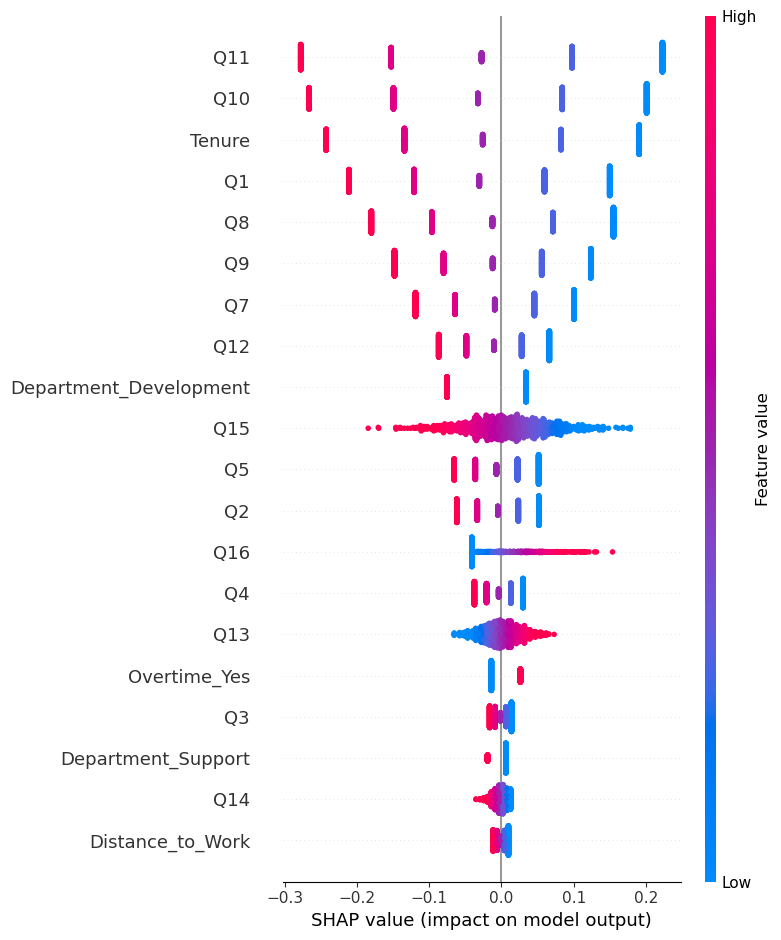

In [20]:
# Create SHAP explainer
explainer = shap.LinearExplainer(best_lr, X_train_encoded, feature_perturbation="interventional")

# Compute SHAP values for the test set
shap_values = explainer.shap_values(X_test_encoded)

# Print SHAP Values Shape
print("SHAP Values Shape:", shap_values.shape)

# Visualize SHAP summary plot
shap.summary_plot(
    shap_values,
    X_test_encoded,
    feature_names=all_feature_names
)

# Saving preprocessor,model and threshold

In [21]:
# Paths to save the model, threshold, and preprocessor
model_path = r"C:\Users\alexa\OneDrive\AlexPerez\Dokumente\2 Soros\Data Science\Projects\employee_attrition_Dec24\models\logistic_regression_model.pkl"
threshold_path = r"C:\Users\alexa\OneDrive\AlexPerez\Dokumente\2 Soros\Data Science\Projects\employee_attrition_Dec24\models\logistic_regression_threshold.pkl"
preprocessor_path = r"C:\Users\alexa\OneDrive\AlexPerez\Dokumente\2 Soros\Data Science\Projects\employee_attrition_Dec24\models\preprocessor.pkl"

# Save the model
joblib.dump(best_lr, model_path)
print(f"Model saved at: {model_path}")

# Save the threshold (adjusted at 0.3)
final_threshold = 0.3
joblib.dump(final_threshold, threshold_path)
print(f"Threshold saved at: {threshold_path}")

# Save preprocessor
joblib.dump(preprocessor, preprocessor_path)
print(f"Preprocessor saved at: {preprocessor_path}")

Model saved at: C:\Users\alexa\OneDrive\AlexPerez\Dokumente\2 Soros\Data Science\Projects\employee_attrition_Dec24\models\logistic_regression_model.pkl
Threshold saved at: C:\Users\alexa\OneDrive\AlexPerez\Dokumente\2 Soros\Data Science\Projects\employee_attrition_Dec24\models\logistic_regression_threshold.pkl
Preprocessor saved at: C:\Users\alexa\OneDrive\AlexPerez\Dokumente\2 Soros\Data Science\Projects\employee_attrition_Dec24\models\preprocessor.pkl


# Testing save model before using Streamlit

In [22]:
print("Expected Feature Order:", all_feature_names)
print("Number of Features:", len(all_feature_names))

Expected Feature Order: ['Gender_Male', 'Department_Development', 'Department_Management', 'Department_QA', 'Department_Support', 'Overtime_Yes', 'Age', 'Tenure', 'Salary', 'Distance_to_Work', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11', 'Q12', 'Q13', 'Q14', 'Q15', 'Q16']
Number of Features: 26


In [23]:
import joblib
import numpy as np
import pandas as pd

# Load the saved logistic regression model, threshold, and preprocessor
model_path = r"C:\Users\alexa\OneDrive\AlexPerez\Dokumente\2 Soros\Data Science\Projects\employee_attrition_Dec24\models\logistic_regression_model.pkl"
threshold_path = r"C:\Users\alexa\OneDrive\AlexPerez\Dokumente\2 Soros\Data Science\Projects\employee_attrition_Dec24\models\logistic_regression_threshold.pkl"
preprocessor_path = r"C:\Users\alexa\OneDrive\AlexPerez\Dokumente\2 Soros\Data Science\Projects\employee_attrition_Dec24\models\preprocessor.pkl"

model = joblib.load(model_path)
threshold = joblib.load(threshold_path)
preprocessor = joblib.load(preprocessor_path)

# Example input values (before preprocessing)
example_input_raw = {
    "Gender": "Female",
    "Department": "DevOps",  # Choose among "Development", "QA", "Support", "Management", "DevOps"
    "Overtime": "Yes",
    "Age": 45,
    "Tenure": 2,
    "Salary": 100000,
    "Distance_to_Work": 10,
    "Q1": 5, "Q2": 5, "Q3": 4, "Q4": 4, "Q5": 3, "Q6": 3, "Q7": 5, "Q8": 5,
    "Q9": 4, "Q10": 1, "Q11": 1, "Q12": 1, "Q13": 5, "Q14": 5, "Q15": 4, "Q16": 5
}

# Convert the input dictionary into a pandas DataFrame
example_input_df = pd.DataFrame([example_input_raw])

# Preprocess the input using the saved preprocessor
example_input_encoded = preprocessor.transform(example_input_df)

# Predict attrition
prob = model.predict_proba(example_input_encoded)[0][1]  # Probability of attrition (class 1)
prediction = 1 if prob >= threshold else 0
print(f"Attrition Prediction: {'Yes' if prediction == 1 else 'No'}")
print(f"Probability of Attrition: {prob * 100:.2f}%")


Attrition Prediction: No
Probability of Attrition: 0.00%


In [24]:
# Another test

import joblib
import pandas as pd
import numpy as np

# Paths to the saved model, threshold, and preprocessor
model_path = r"C:\Users\alexa\OneDrive\AlexPerez\Dokumente\2 Soros\Data Science\Projects\employee_attrition_Dec24\models\logistic_regression_model.pkl"
threshold_path = r"C:\Users\alexa\OneDrive\AlexPerez\Dokumente\2 Soros\Data Science\Projects\employee_attrition_Dec24\models\logistic_regression_threshold.pkl"
preprocessor_path = r"C:\Users\alexa\OneDrive\AlexPerez\Dokumente\2 Soros\Data Science\Projects\employee_attrition_Dec24\models\preprocessor.pkl"

# Load the saved model, threshold, and preprocessor
model = joblib.load(model_path)
threshold = joblib.load(threshold_path)
preprocessor = joblib.load(preprocessor_path)

# Define a test case with DevOps
raw_input_data = pd.DataFrame({
    "Gender": ["Female"],  # Female encoded as 0
    "Department": ["DevOps"],  # This should ensure all other department columns are 0
    "Overtime": ["Yes"],  # Yes encoded as 1
    "Age": [45],  # Example age
    "Tenure": [2],  # Example tenure
    "Salary": [100000],  # Example salary
    "Distance_to_Work": [10],  # Example distance
    "Q1": [5], "Q2": [5], "Q3": [4], "Q4": [4], "Q5": [3], "Q6": [3], 
    "Q7": [5], "Q8": [5], "Q9": [4], "Q10": [1], "Q11": [1], "Q12": [1], 
    "Q13": [5], "Q14": [5], "Q15": [4], "Q16": [5]  # Example Q12+ responses
})

# Encode the input using the preprocessor
encoded_input = preprocessor.transform(raw_input_data)

# Verify encoded input shape and structure
print("Encoded Input Shape:", encoded_input.shape)
print("Encoded Input:", encoded_input)

# Predict probabilities using the model
prob = model.predict_proba(encoded_input)[0][1]  # Probability of attrition (class 1)
prediction = 1 if prob >= threshold else 0

# Output the results
print(f"Attrition Prediction: {'Yes' if prediction == 1 else 'No'}")
print(f"Probability of Attrition: {prob * 100:.2f}%")


Encoded Input Shape: (1, 26)
Encoded Input: [[0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 1.0e+00 5.0e+00 5.0e+00 4.0e+00
  4.0e+00 3.0e+00 3.0e+00 5.0e+00 5.0e+00 4.0e+00 1.0e+00 1.0e+00 1.0e+00
  5.0e+00 5.0e+00 4.0e+00 5.0e+00 4.5e+01 2.0e+00 1.0e+05 1.0e+01]]
Attrition Prediction: No
Probability of Attrition: 0.00%


## Debugging checks

In [25]:
#1- Verify preprocessing pipeline: Ensure the preprocessor is working correctly by checking the encoded input and confirming the alignment of features

print("Raw Input:")
print(example_input_df)
print("\nEncoded Input (After Preprocessing):")
print(example_input_encoded)


Raw Input:
   Gender Department Overtime  Age  Tenure  Salary  Distance_to_Work  Q1  Q2  \
0  Female     DevOps      Yes   45       2  100000                10   5   5   

   Q3  Q4  Q5  Q6  Q7  Q8  Q9  Q10  Q11  Q12  Q13  Q14  Q15  Q16  
0   4   4   3   3   5   5   4    1    1    1    5    5    4    5  

Encoded Input (After Preprocessing):
[[0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 1.0e+00 5.0e+00 5.0e+00 4.0e+00
  4.0e+00 3.0e+00 3.0e+00 5.0e+00 5.0e+00 4.0e+00 1.0e+00 1.0e+00 1.0e+00
  5.0e+00 5.0e+00 4.0e+00 5.0e+00 4.5e+01 2.0e+00 1.0e+05 1.0e+01]]


In [26]:
print("Feature Names from Preprocessor:", preprocessor.get_feature_names_out())


Feature Names from Preprocessor: ['cat__Gender_Male' 'cat__Department_Development'
 'cat__Department_Management' 'cat__Department_QA'
 'cat__Department_Support' 'cat__Overtime_Yes' 'remainder__Q1'
 'remainder__Q2' 'remainder__Q3' 'remainder__Q4' 'remainder__Q5'
 'remainder__Q6' 'remainder__Q7' 'remainder__Q8' 'remainder__Q9'
 'remainder__Q10' 'remainder__Q11' 'remainder__Q12' 'remainder__Q13'
 'remainder__Q14' 'remainder__Q15' 'remainder__Q16' 'remainder__Age'
 'remainder__Tenure' 'remainder__Salary' 'remainder__Distance_to_Work']


In [27]:
#2. Inspect models performance: Test model in notebook to verify it produces varying probabilies 

print("Testing with training data:")
X_train_sample = X_train_encoded[:5]  # A small sample of the encoded training data
y_pred_train_prob = model.predict_proba(X_train_sample)[:, 1]
print("Sample Probabilities:", y_pred_train_prob)


Testing with training data:
Sample Probabilities: [0.22891277 0.15452413 0.34590685 0.168466   0.71410088]


In [28]:
#3. Check feature order: Ensure the feature order of example_input_encoded matches the model’s expectations


print("Expected Feature Order from Preprocessor:")
print(preprocessor.get_feature_names_out())


Expected Feature Order from Preprocessor:
['cat__Gender_Male' 'cat__Department_Development'
 'cat__Department_Management' 'cat__Department_QA'
 'cat__Department_Support' 'cat__Overtime_Yes' 'remainder__Q1'
 'remainder__Q2' 'remainder__Q3' 'remainder__Q4' 'remainder__Q5'
 'remainder__Q6' 'remainder__Q7' 'remainder__Q8' 'remainder__Q9'
 'remainder__Q10' 'remainder__Q11' 'remainder__Q12' 'remainder__Q13'
 'remainder__Q14' 'remainder__Q15' 'remainder__Q16' 'remainder__Age'
 'remainder__Tenure' 'remainder__Salary' 'remainder__Distance_to_Work']


In [29]:
#4. Examine threshold logic: is the threshold being applied correctly?

print("Probability of Attrition:", prob)
print("Threshold:", threshold)


Probability of Attrition: 0.0
Threshold: 0.3


In [30]:
#5.Test model with known training data

train_sample_encoded = X_train_encoded[:1]  # First row of training data
train_sample_prob = model.predict_proba(train_sample_encoded)[0][1]
train_sample_pred = model.predict(train_sample_encoded)[0]
print(f"Training Sample Prediction: {'Yes' if train_sample_pred == 1 else 'No'}")
print(f"Training Sample Probability: {train_sample_prob * 100:.2f}%")


Training Sample Prediction: No
Training Sample Probability: 22.89%


In [31]:
#6. check the model's learned coefficients and intercept

# Load the model
model = joblib.load(model_path)

# Check the coefficients and intercept
print("Model Coefficients:", model.coef_)
print("Intercept:", model.intercept_)


Model Coefficients: [[-0.00399098 -0.10927426  0.01868363  0.02691478 -0.02525897  0.04022209
  -0.00061915 -0.10823198 -0.00430527 -0.00530183 -0.09016752 -0.02836164
  -0.00754968 -0.0168063  -0.02920561 -0.00308208 -0.05480665 -0.08371315
  -0.06786221 -0.11671858 -0.12505402 -0.03824284  0.03362346 -0.01591381
  -0.07729973  0.07591166]]
Intercept: [2.08049409]


In [32]:
#7. Test preprocessed inputs

# Encode the raw input data
encoded_input = preprocessor.transform(raw_input_data)

# Check the encoded inputs
print("Encoded Input Shape:", encoded_input.shape)
print("Encoded Input:", encoded_input)


Encoded Input Shape: (1, 26)
Encoded Input: [[0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 1.0e+00 5.0e+00 5.0e+00 4.0e+00
  4.0e+00 3.0e+00 3.0e+00 5.0e+00 5.0e+00 4.0e+00 1.0e+00 1.0e+00 1.0e+00
  5.0e+00 5.0e+00 4.0e+00 5.0e+00 4.5e+01 2.0e+00 1.0e+05 1.0e+01]]


In [33]:
#8 Use test data from the notebook
y_pred_test = model.predict_proba(X_test_encoded)[:, 1]  # Predicted probabilities
print("Predicted Probabilities on Test Set:", y_pred_test[:10])  # Show first 10 predictions


Predicted Probabilities on Test Set: [0.75743284 0.18321348 0.16156452 0.1698443  0.30846894 0.37184118
 0.7436208  0.67850873 0.28058958 0.72041315]


In [34]:
#9 Check treshold application

# Load the threshold and test it
threshold = joblib.load(threshold_path)
print("Loaded Threshold:", threshold)

# Apply the threshold to a known probability
test_prob = 0.6  # Example probability
prediction = 1 if test_prob >= threshold else 0
print(f"Prediction for Probability {test_prob}: {'Yes' if prediction == 1 else 'No'}")


Loaded Threshold: 0.3
Prediction for Probability 0.6: Yes
